In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
import networkx as nx
from collections import deque
%pip install geopandas
import geopandas as gpd

     |████████████████████████████████| 972kB 6.6MB/s 
     |████████████████████████████████| 6.5MB 16.9MB/s 
     |████████████████████████████████| 14.8MB 296kB/s 


Leeremos el grafo desde nuestro csv

In [3]:
# Importamos nuestro drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/Proyecto Combinatorial COVID/corrected_graph.csv'
csv_grafo = pd.read_csv(path)
csv_grafo.head()
#csv_grafo[csv_grafo['direccion'] == 9999]

,Unnamed: 0,self,other,red_id,direccion,notas
0,0,146338,146339,159250,0,Success
1,1,146339,139543,159251,0,Success
2,2,146340,139542,159252,0,Success
3,3,146340,146336,159253,0,Success
4,4,146337,146336,159254,0,Success


Instanciamos el grafo

In [ ]:
G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
  origin = row['self']
  dest = row['other']
  d = row['direccion']
  if d != 9999:   # Ignoramos los nodos a los que les falta información
    G.add_edge(origin, dest)
for node in G.nodes:
  G.nodes[node]['weight'] = 100 #Asumimos tener 100 personas por nodo en primera instancia

In [ ]:
#nx.draw(G, with_labels=True)
#plt.show()

In [5]:
def collapse_cicles(Graph, limit):
  G = Graph.to_undirected()
  cicles = nx.algorithms.cycles.cycle_basis(G)
  ignored = list()
  skipped = list()
  new = len(G.nodes) + 1
  
  while cicles: 
    cicle = cicles.pop()
    cicle_weight =  sum([G.nodes[i]['weight'] for i in cicle])
    # Todos los nodos dentro de los ciclos
    cicle_nodes = [item for sublist in cicles for item in sublist]

    # obtemos los vecinos del ciclo y expandimos la lista
    predecessors = [Graph.predecessors(i) for i in cicle]
    predecessors = [item for sublist in predecessors for item in sublist]
    successors = [Graph.successors(i) for i in cicle]
    successors = [item for sublist in successors for item in sublist]

    # Agregamos el nodo que reemplazará el ciclo. Agregamos las aristas correspondientes y su peso. 
    if cicle_weight <= limit:
      G.add_node(new)
      G.nodes[new]['weight'] = cicle_weight
      Graph.add_node(new)
      Graph.nodes[new]['weight'] = cicle_weight

      # Agregamos los nodos que entran y que salen del ciclo
      for node in predecessors:
        if node not in cicle_nodes:
          G.add_edge(node, new)
          Graph.add_edge(node, new)
      for node in successors:
        if node not in cicle_nodes:
          G.add_edge(new, node)
          Graph.add_edge(new, node)
      # Removemos los nodos del ciclo
      for node in cicle:
        G.remove_node(node)
        Graph.remove_node(node)
      new += 1
    else:
      ignored.append(cicle)
      skipped.append(cicle_weight)

    # Actualizamos la lista de ciclos ya que puede cambiar. Ignoramos aquellos por los que pasamos pero que eran 
    # muy numerosos para comprimirlos
    cicles = [i for i in nx.algorithms.cycles.cycle_basis(G) if i not in ignored]
    cicle_nodes = [item for sublist in cicles for item in sublist]
  return Graph, skipped

In [ ]:
G1 = G.copy()
print(f'nodos iniciales: {len(G1.nodes)}')
corrected, skipped = collapse_cicles(G1, 2000)
print(f'nodos finales: {len(corrected.nodes)}')
print(f'cantidad de ciclos sin eliminar {len(skipped)}')

nodos iniciales: 24545


KeyboardInterrupt: ignored

## Instancia San Pedro 

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


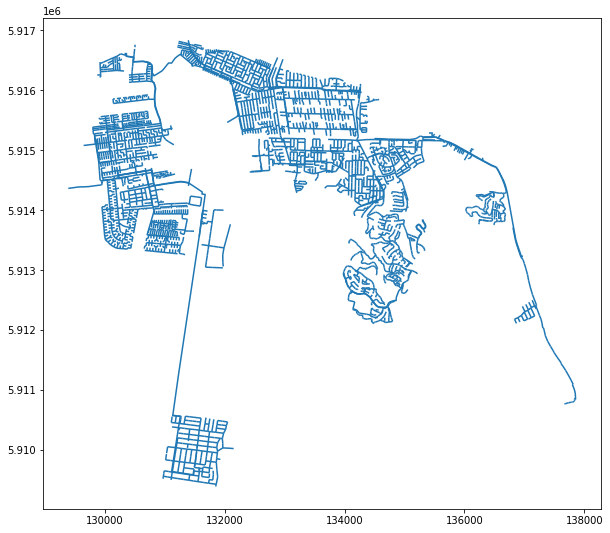

In [7]:
path = '/content/drive/My Drive/Proyecto Combinatorial COVID/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
#geometry.plot()
f, ax = plt.subplots(1, figsize=(10, 10))
ax = geometry.plot(axes=ax)
plt.show()

In [8]:
path = '/content/drive/My Drive/Proyecto Combinatorial COVID/graph_geom_corrected_cycles.csv'
san_pedro_csv = pd.read_csv(path, sep = ';')
path_pesos = '/content/drive/My Drive/Proyecto Combinatorial COVID/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)
pesos.head()

,ID_tapa,per_predio
0,111663,7.781733
1,111664,52.549419
2,111665,70.218023
3,111666,6.945736
4,111667,42.931473


In [9]:
G_sp = nx.DiGraph()
for index, row in san_pedro_csv.iterrows():
  origin = row['self']
  dest = row['other']
  G_sp.add_edge(origin, dest)
for node in G_sp.nodes:
  if pesos[pesos['ID_tapa'] == node].shape[0] >= 1:
    G_sp.nodes[node]['weight'] = pesos[pesos['ID_tapa'] == node].iloc[0]['per_predio']
  else:
    G_sp.nodes[node]['weight'] = 0

In [ ]:
G2 = G_sp.copy()
print(f'nodos iniciales: {len(G2.nodes)}')
corrected_sp, skipped = collapse_cicles(G2, 1200)
print(f'nodos finales: {len(corrected_sp.nodes)}')
print(f'cantidad de ciclos sin eliminar {len(skipped)}')

nodos iniciales: 4603
nodos finales: 3847
cantidad de ciclos sin eliminar 0


In [ ]:
#save_graph(corrected_sp,"corrected_sp.pdf")

# Pruebas

Partiremos instanciando un arbol arbitrario al que le agregaremos aristas extras con el fin de crear ciclos.

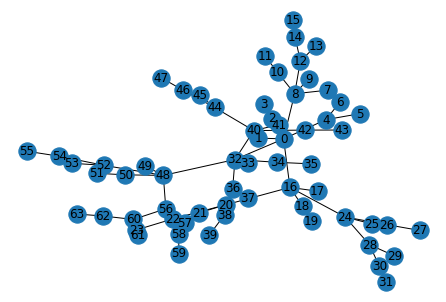

In [ ]:
almost_tree = nx.generators.classic.binomial_tree(6)
almost_tree.add_edge(7,8)
almost_tree.add_edge(25,26)
almost_tree.add_edge(51,52)
for node in almost_tree.nodes():
  almost_tree.nodes[node]['weight'] = 10
nx.draw(almost_tree, with_labels=True)
plt.show()

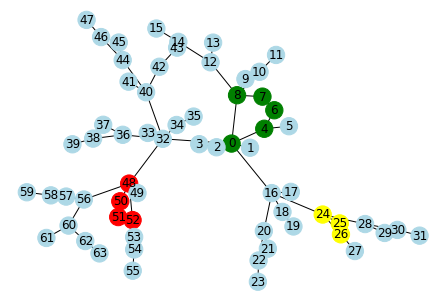

In [ ]:
cicles = nx.algorithms.cycles.cycle_basis(almost_tree)
# Graficamos cuales son estos ciclos
color_map = []
for node in almost_tree:
    if node in cicles[0]:
        color_map.append('red')
    elif node in cicles[1]:
        color_map.append('yellow')
    elif node in cicles[2]:
        color_map.append('green')
    else: 
        color_map.append('lightblue')      
nx.draw(almost_tree, node_color=color_map, with_labels=True)
plt.show()

In [ ]:
cicles
weights =  [almost_tree.nodes[i]['weight'] for i in cicles[1]]
weights

[10, 10, 10]

número de ciclos: 0


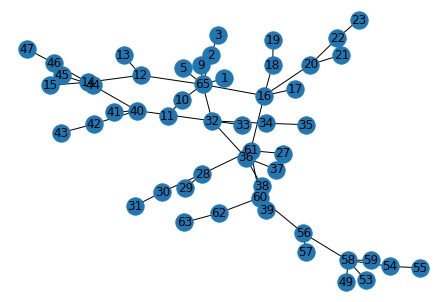

In [ ]:
# instanciamos el grafo
almost_tree = nx.generators.classic.binomial_tree(6)
almost_tree.add_edge(7,8)
almost_tree.add_edge(25,26)
almost_tree.add_edge(51,52)

collapsed_tree = collapse_cicles(almost_tree)
cicles = nx.algorithms.cycles.cycle_basis(collapsed_tree)
print(f'número de ciclos: {len(cicles)}')

# graficamos el resultado
nx.draw(collapsed_tree, with_labels=True)
plt.show()

In [ ]:
prueba = nx.path_graph(4)
prueba.add_edge(3,1)
collapsed = collapse_cicles(prueba)
collapsed.edges

EdgeView([(0, 5)])

In [ ]:
dc = G = nx.DiGraph()
dc.add_edge(1,2)
dc.add_edge(2,3)
dc.add_edge(3,4)
dc.add_edge(4,2)
for node in dc.nodes:
  dc.nodes[node]['weight'] = 10
#new = collapse_cicles(dc, 100)
#new.nodes

In [ ]:
#nx.draw(corrected)
#plt.savefig("graph.pdf")
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph g has nodes and edges entered
save_graph(dc,"corrected.pdf")

NameError: ignored

# Greedy

In [10]:
def get_size(G, V_, N, u):
    
    V = V_.copy()
    
    ans = 1;  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                ans += 1; V[v] = 1
                Q.append(v)
    
    return ans

def visit(G, V, u):
    V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                V[v] = 1
                Q.append(v)
    
    return V

In [11]:
def greedyApp(G, N, K, limit):
    
    E = []
    V = [0 for u in range(N)]
    for u in range(N):
        E.append((get_size(G, V, N, u), u))

    S = set()
    for e in E:
        if e[0] < limit:
            S.add(e[1])

    ans = []
    count = 0
    while count < K:
        maxv = 0; u = -1
        for v in S:
            s = get_size(G, V, N, v)
            if s > maxv:
                u = v
                maxv = s

        V = visit(G, V, u)
        ans.append(u)
        S.remove(u)
        count += 1

    return ans

In [12]:
G = nx.DiGraph()

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    d = row['direccion']
    if d != 9999:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; l = 0
for u in S:
    id_[u] = l
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    d = row['direccion']
    if d != 9999:
        G.add_edge(id_[origin], id_[dest])
for node in G.nodes:
    G.nodes[node]['weight'] = 100
    
N = l

In [ ]:
ans = greedyApp(G, N, 10, 2000)
print(ans)

for u in ans:
    print(get_size(G, [0 for v in range(N)], N, u))

[19560, 6600, 15931, 11285, 17193, 13875, 7474, 22309, 5956, 24521]
806
659
616
595
532
481
448
407
391
342


Pruebas para ver cómo afecta el límite impuesto a la cantidad de nodos visitados

In [13]:
def visited(G, V):
    G = G.copy()
    v = sum([1 for node in G.nodes if V[node] == 1])
    return v 

def greedyApp_cover(G, N, K, limit):
    G = G.copy()

    E = []
    # Lista de ignorados
    I = []
    V = [0 for u in range(N)]
    for u in range(N):
        E.append((get_size(G, V, N, u), u))

    S = set()
    for e in E:
        if e[0] < limit:
            S.add(e[1])
        elif  e[0] >= limit:
            I.append(e[1])

    ans = []
    count = 0
    while count < K:
        maxv = 0; u = -1
        for v in S:
            s = get_size(G, V, N, v)
            if s > maxv:
                u = v
                maxv = s

        V = visit(G, V, u)
        ans.append(u)
        S.remove(u)
        count += 1

    ignored = len(I)
    total = len(G.nodes)
    v = sum([1 for node in G.nodes if V[node] == 1])
    return v, total, ignored 

In [ ]:
v, total, ignored = greedyApp_cover(G, N, 10, 2000)
print(v , total, ignored)

4194 4603 122


In [14]:
path = '/content/drive/My Drive/Proyecto Combinatorial COVID/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

G = nx.DiGraph()

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; l = 0
for u in S:
    id_[u] = l
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    G.add_edge(id_[origin], id_[dest])
for node in G.nodes:
    G.nodes[node]['weight'] = 100
    
N = l

In [15]:
limit_ = [100, 200, 400]
k_ = [10, 20, 30, 40, 50]
results = {}
for limit in limit_:
  for k in k_:
    visited, total, ignored = greedyApp_cover(G, N, k, limit)
    results[(k,limit)] =  visited
    print(f'k: {k}, limit: {limit} => visited: {round(visited/total*100, 2)}%, ignored: {ignored}, total = {total}')

k: 10, limit: 100 => visited: 21.05%, ignored: 545, total = 4603
k: 20, limit: 100 => visited: 39.3%, ignored: 545, total = 4603
k: 30, limit: 100 => visited: 52.21%, ignored: 545, total = 4603
k: 40, limit: 100 => visited: 61.61%, ignored: 545, total = 4603
k: 50, limit: 100 => visited: 68.89%, ignored: 545, total = 4603
k: 10, limit: 200 => visited: 33.72%, ignored: 410, total = 4603
k: 20, limit: 200 => visited: 55.36%, ignored: 410, total = 4603
k: 30, limit: 200 => visited: 68.82%, ignored: 410, total = 4603
k: 40, limit: 200 => visited: 77.08%, ignored: 410, total = 4603
k: 50, limit: 200 => visited: 81.92%, ignored: 410, total = 4603
k: 10, limit: 400 => visited: 63.35%, ignored: 284, total = 4603
k: 20, limit: 400 => visited: 82.12%, ignored: 284, total = 4603
k: 30, limit: 400 => visited: 87.53%, ignored: 284, total = 4603
k: 40, limit: 400 => visited: 90.14%, ignored: 284, total = 4603
k: 50, limit: 400 => visited: 91.51%, ignored: 284, total = 4603


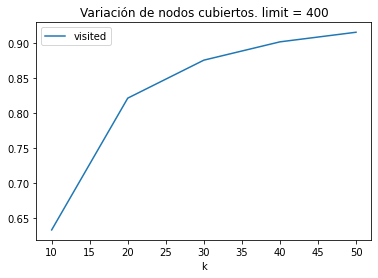

In [16]:
results
results_df = pd.DataFrame({"k" : [i[0] for i in results.keys()], "limit" : [i[1] for i in results.keys()], "visited" : [i /4603 for i in results.values()]})
results_df[results_df["limit"] == 400][["k", "visited"]].plot( x = "k", title = 'Variación de nodos cubiertos. limit = 400')

In [ ]:
results_df

,k,limit,visited
0,10,100,0.210515
1,20,100,0.393005
2,30,100,0.522051
3,40,100,0.616120
4,50,100,0.688899
5,10,200,0.337171
6,20,200,0.553552
7,30,200,0.688247
8,40,200,0.770802
9,50,200,0.819248


## Testing Max time to find

In [ ]:
def greedyAppNew(G, V_, N, K, limit):
    
    V = V_.copy()
    
    E = []
    for u in range(N):
        if not V[u]:
            E.append((get_size(G, V, N, u), u))

    S = set()
    for e in E:
        if e[0] > 0 and e[0] <= limit:
            S.add(e[1])

    ans = []
    count = 0
    while count < K:
        maxv = 0; u = -1
        for v in S:
            s = get_size(G, V, N, v)
            if s > maxv:
                u = v
                maxv = s
        if u == -1:
            break

        V, _ = visit(G, V, u)
        ans.append(u)
        S.remove(u)
        count += 1

    return ans

In [ ]:
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')
csv_grafo.head()

G = nx.DiGraph()

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; l = 0
for u in S:
    id_[u] = l
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    G.add_edge(id_[origin], id_[dest])
for node in G.nodes:
    G.nodes[node]['weight'] = 100
    
N = l

FileNotFoundError: ignored

In [ ]:
def add_visit(G, N, V, u):
    
    V_ = [0 for u in range(N)]
    
    V[u] += 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V_[v]:
                V[v] += 1
                V_[v] = 1
                Q.append(v)
                
def deactivate(G, V, u):
    V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                V[v] = 1
                Q.append(v)

T = []
for r in range(N):
    CV = [0 for u in range(N)]

    CV[r] = 1
    Q = deque([]); Q.append(r)
    while Q:
        u = Q.popleft()
        for v in G.successors(u):
            if not CV[v]:
                CV[v] = 1
                Q.append(v)
    V = [0 for u in range(N)]

    R = N
    for t in range(100):
        P = greedyAppNew(G, V, N, 10, R / 2)
        if sum([CV[p] for p in P]) > 0:
            V = [0 for u in range(N)]
            for p in P:
                if CV[p]:
                    add_visit(G, N, V, p)
            for u in range(N):
                if V[u] == sum([CV[p] for p in P]):
                    V[u] = 0
                else:
                    V[u] = 1
        for p in P:
            if not V[p] and not CV[p]:
                deactivate(G, V, p)

        R = sum([1 - V[u] for u in range(N)])

        if R == 1:
            for u in range(N):
                if not V[u]:
                    print(u, t + 1)
                    T.append(t + 1)
            break
        if t == 99:
            print(r, "*******************")
            T.append(100)
    

Results: max time = 20 its, mean time = 6.28

## Size of Ideals

In [ ]:
path = '/content/drive/My Drive/Proyecto Combinatorial COVID/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')
path_pesos = '/content/drive/My Drive/Proyecto Combinatorial COVID/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

csv_grafo.head()

In [ ]:
G = nx.DiGraph()

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    G.add_edge(id_[origin], id_[dest])
for node in G.nodes:
    G.nodes[node]['weight'] = 0
    
N = l

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        G.nodes[u]['weight'] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [ ]:
def get_weight_size(G, N, u):
    
    V = [0 for u in range(N)]
    
    w = G.nodes[u]['weight']; s = 1;  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                w += G.nodes[v]['weight']; s += 1
                V[v] = 1; Q.append(v)
    
    return w, s

dd = {'id': [], 'ideal weight': [], 'ideal size': []}
for u in range(N):
    
    w, s = get_weight_size(G, N, u)
    
    dd['id'].append(_id[u])
    dd['ideal weight'].append(w)
    dd['ideal size'].append(s)
    #print(_id[u], get_weight_size(G, N, u))
df = pd.DataFrame(data=dd)

In [ ]:
df.to_csv('/content/drive/My Drive/Proyecto Combinatorial COVID/ideal_weight.csv', index=False)